# Building Decision Trees and Random Forests
In this notebook we will build decision tree and random forest classes that will act as classifiers on the Titanic dataset. The features of the dataset describe the passenger, and the label describes whether or not they survived. 

Dataset Credits: Professor Shewchuk's CS189 Spring 2017

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
%matplotlib inline

In [14]:
from scipy.io import loadmat as loadmat
import matplotlib.pyplot as plt

titanicDataFrame = pd.read_csv('titanic_training.csv')
titanicDataFrame.head()

,survived,pclass,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,0.0,3.0,male,NaN,0.0,0.0,SOTON/OQ 392086,8.0500,NaN,S
1,0.0,1.0,male,22.0,0.0,0.0,PC 17760,135.6333,NaN,C
2,0.0,2.0,male,23.0,0.0,0.0,SC/PARIS 2133,15.0458,NaN,C
3,0.0,2.0,male,42.0,0.0,0.0,211535,13.0000,NaN,S
4,0.0,3.0,male,20.0,0.0,0.0,7534,9.8458,NaN,S


In [27]:
titanicLabels = titanicDataFrame.iloc[:,0]
titanicData = titanicDataFrame.iloc[:,1:]

titanicData.drop('ticket', axis=1, inplace=True)
titanicData.dropna(axis=0, how="all", inplace=True)
titanicLabels.dropna(axis=0, how="all", inplace=True)
for i in range(titanicData.shape[0]):
    if not pd.isnull(titanicData.iloc[i,6]):
        titanicData.iloc[i,6] = titanicData.iloc[i,6][0]
    else:
        titanicData.iloc[i,6] = "H"

titanicData = pd.get_dummies(titanicData, drop_first=True).fillna(value=0, axis=1)
print(titanicData.shape)
titanicData.head()

(999, 16)


,pclass,age,sibsp,parch,fare,sex_male,cabin_B,cabin_C,cabin_D,cabin_E,cabin_F,cabin_G,cabin_H,cabin_T,embarked_Q,embarked_S
0,3.0,0.0,0.0,0.0,8.0500,1,0,0,0,0,0,0,1,0,0,1
1,1.0,22.0,0.0,0.0,135.6333,1,0,0,0,0,0,0,1,0,0,0
2,2.0,23.0,0.0,0.0,15.0458,1,0,0,0,0,0,0,1,0,0,0
3,2.0,42.0,0.0,0.0,13.0000,1,0,0,0,0,0,0,1,0,0,1
4,3.0,20.0,0.0,0.0,9.8458,1,0,0,0,0,0,0,1,0,0,1


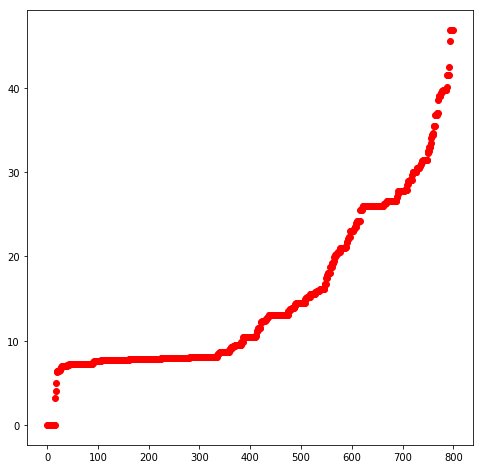

In [20]:
x = np.arange(800)
plt.figure(figsize=(8,8))
plt.plot(x, np.sort(titanicData['fare'].values)[:800], 'ro')
plt.show()
#easily split on 1/10 of the values for fare 

## Cross Entropy Code
Try to understand the different parts of the code. 
- What do a, b, c, d represent?
- What do t1, t2 represent?

In [21]:
def cross_entropy(l1, l0, r1, r0):
    """
    Calculate the entropy H_after, if after the split we have:
    l1, l0 -> The left split, broken into the sets that are 1's and 0's.
    r1, r0 -> The right split, broken into the sets that are 1's and 0's.
    """
    t1 = 0
    lsize = l1 + l0
    if lsize > 0:
        a = float(l1) / lsize            
        b = 1 - a
        if a != 0 and b != 0:
            t1 += a * np.log(a)
            t1 += b * np.log(b)
        t1 *= lsize
    
    t2 = 0
    rsize = r1 + r0
    if rsize > 0:
        c = float(r1) / rsize
        d = 1 - c
        if c != 0 and d != 0:
            t2 += c * np.log(c)
            t2 += d * np.log(d)
        t2 *= rsize
    #returns weighted total entropy
    return -1 * (t1 + t2) / (lsize + rsize)

## Decision Tree Code
Recall that in a tree, all children are also classified as "trees," i.e. A decision tree is always a tree of decision trees. 

In [37]:
class DecisionTree: 
    def __init__(self, dataSet, labels, stopCriterion, depth, fselection=False, printer=False):
        """
        Initialize a Decision Tree using the arguments:
            dataSet, labels         : will be used to determine next split
            stopCriterion           : [(majority/depth), value]
            depth                   : the depth of this Decision Tree 
            fselection              : whether this tree will employ random feature selection
        Also create instance variables:
            stopCriterion           : turns from argument to a function. Use this function to judge when to stop.
            stopParam               : this will be the argument to the stopCriterion function
            leftNode, rightNode     : the tree's children
            leaf, val               : leaf is whether the node is a leaf, val is what value the leaf holds
            decision, decisionString: branching rule and string representation of the rule
        Then proceed to growTree()     
        """
        self.dataSet = dataSet
        self.labels = labels
        self.depth = depth
        self.fselection = fselection
        
        self.stopParam = None
        self.stopCritString = stopCriterion[0]
        if stopCriterion[0] == "majority":
            self.stopCriterion = self.majorityCriterion
            self.stopParam = stopCriterion[1]
        elif stopCriterion[0] == "depth":
            self.stopCriterion = self.maxDepth
            self.stopParam = stopCriterion[1]
        
        self.leftNode = None
        self.rightNode = None
        self.leaf = False
        self.val = None
        self.entropy = cross_entropy(np.sum(self.labels.values), self.labels.values.size - np.sum(self.labels.values), 0, 0)
        
        self.decision = None
        self.decisionString = ""
        self.growTree()
        if depth == 0 and printer:
            print("Finished making Decision Tree with criteria: " + str(stopCriterion))
        
    def majorityCriterion(self, value):
        """
        Determines if the larger part of the set is majority by at least the fraction "value"
        """
        thesum = np.sum(self.labels.values)
        thesize = self.labels.values.size
        return thesum <= (1 - value) * thesize or thesum >= value * thesize
    
    def maxDepth(self, value):
        """
        An OR between hitting max depth and some majority value (no need to split further needlessly)
        """
        if self.depth == value:
            return True
        thesum = np.sum(self.labels.values)
        thesize = self.labels.values.size
        return thesum >= 0.85 * thesize or thesum <= 0.15 * thesize
    
    def growTree(self):
        """
        growTree() as described in lecture.
        """
        # dataSet is a pandas dataframe
        workingData = self.dataSet
        workingLabels = self.labels
        dataLength = self.labels.size

        featureNames = list(workingData.columns.values)
        if self.fselection:
            numFeatures = min(max(int(np.sqrt(len(featureNames))), 9) + 1, len(featureNames)) # at least 10 features
            np.random.shuffle(featureNames)
            featureNames = featureNames[:numFeatures]
            
        bestEntropy = self.entropy # starting value of entropy is the entropy of the node itself
        totalOnes = np.sum(workingLabels)
        bestFeatureSplit = []
        
        if self.stopCriterion(self.stopParam):
            # don't actually grow tree in this case.
            self.val = round(np.sum(self.labels.values)/self.labels.values.size)
            self.leaf = True
            return
        
        for feature in featureNames:
            joined = pd.concat([workingData[feature], workingLabels], axis=1).sort_values(feature) # sort by feature
            uniqueValues = joined[feature].unique()
            numValues = uniqueValues.size # how many unique values

            splitNumber = min(max(int(0.1 * numValues), 50), numValues) - 1 # get a reasonable number of splits   
            
            featureVals = joined[feature].values
            labelVals = joined.iloc[:,1].values
            
            ind = 0
            leftones = 0
            rightones = totalOnes
            for i in range(splitNumber):
                # now we grab indices off the uniqueValues, scan lists
                # split on a less than or equal to criteria at that value
                nextValue = uniqueValues[int(i / splitNumber * numValues)]
                while not (featureVals[ind] == nextValue and not featureVals[ind + 1] == nextValue):
                    leftones += labelVals[ind] # adjusts count of each label for each side of split
                    ind += 1
                # we are at the index that we will be splitting on 
                leftones += labelVals[ind]
                ind += 1
                
                # calculate cross entropy
                rightones -= leftones
                leftzeroes = ind - leftones
                rightzeroes = dataLength - leftones - rightones - leftzeroes
                entropy = cross_entropy(leftones, leftzeroes, rightones, rightzeroes)
                if entropy < bestEntropy:
                    # update bestEntropy if new split is superior
                    bestEntropy = entropy
                    bestFeatureSplit = [feature, ind, nextValue] # all the data required to describe a split
         
        # we have determined the best split by this point. 
        if len(bestFeatureSplit) < 3:
            # this is if for some reason we were unable to find a split better than the current node's composition itself.
            self.val = round(np.sum(self.labels.values)/self.labels.values.size)
            self.leaf = True
            return
        self.decision = lambda x : x[bestFeatureSplit[0]] <= bestFeatureSplit[2] # create decision function
        self.decisionString = "Is " + bestFeatureSplit[0] + " less than or equal to " + str(bestFeatureSplit[2]) + "?"
        
        preparedData = pd.concat([workingLabels, workingData], axis=1).sort_values(bestFeatureSplit[0])
        # join the data back with labels, sort by feature
        nextData = preparedData.iloc[:,1:]
        nextLabels = preparedData.iloc[:,0]
        
        # take the 'ind' from 'bestFeatureSplit' to split into left and right parts. 
        # note the recursive definition of leftNode, rightNode
        leftData = nextData.iloc[:bestFeatureSplit[1],:]
        leftLabels = nextLabels.iloc[:bestFeatureSplit[1]]
        self.leftNode = DecisionTree(leftData, leftLabels, [self.stopCritString, self.stopParam], self.depth + 1)
        
        rightData = nextData.iloc[bestFeatureSplit[1]:,:]
        rightLabels = nextLabels.iloc[bestFeatureSplit[1]:]
        self.rightNode = DecisionTree(rightData, rightLabels, [self.stopCritString, self.stopParam], self.depth + 1)
        
    def classifyPoint(self, point, verbose=False):
        """
        Recursively send a point through the decision tree until it reaches a leaf. 
        Return value at the leaf.
        """
        if self.leaf:
            return self.val
        elif self.decision(point):
            if verbose:
                print(self.decisionString, " (Yes)")
            return self.leftNode.classifyPoint(point, verbose)
        else:
            if verbose:
                print(self.decisionString, " (No)")
            return self.rightNode.classifyPoint(point, verbose)
    
    def score(self, data, labels):
        """
        Get accuracy of classifier on data.
        """
        score = 0
        for i in range(labels.size):
            res = self.classifyPoint(data.iloc[i])
            if res == labels.iloc[i]:
                score += 1
        return float(score) / labels.size


## Random Forest Code

In [43]:
class RandomForest:
    def __init__(self, dataSet, labels, numPoints, numTrees, stopCriterion, printer=False):
        """
        Create a random forest classifier. Arguments are mostly same/self-explanatory. 
        numPoints: number of points to use in training (basically bootstrap aggregating)
        """
        self.numTrees = numTrees
        self.stopCriterion = stopCriterion
        self.trees = []
        self.dataSet = dataSet
        self.labels = labels
        self.numPoints = numPoints
        
        self.growTrees()
        if printer:
            print("Finished Random Forest with %s trees" % (numTrees))
    
    def growTrees(self):
        for i in range(self.numTrees):
            selected = [int(self.labels.size * np.random.rand()) for j in range(self.numPoints)]
            sliceData = self.dataSet.iloc[selected]
            sliceLabels = self.labels.iloc[selected]
            tree = DecisionTree(sliceData, sliceLabels, self.stopCriterion, 0, fselection=True)
            self.trees.append(tree)
    
    def classifyPoint(self, point):
        score = 0
        for i in range(self.numTrees):
            score += self.trees[i].classifyPoint(point)
        return round(float(score) / self.numTrees)
    
    def score(self, data, labels):
        score = 0
        for i in range(labels.size):
            res = self.classifyPoint(data.iloc[i])
            if res == labels.iloc[i]:
                score += 1
        return float(score) / labels.size     

## Try the Classifiers Out

In [39]:
def makeValSplits(data, labels):
    indices = np.arange(labels.size)
    np.random.shuffle(indices)
    length = int(0.8 * indices.size)
    return (data.iloc[indices[:length]], labels.iloc[indices[:length]],
            data.iloc[indices[length:]], labels.iloc[indices[length:]])

trainData, trainLabels, valData, valLabels = makeValSplits(titanicData, titanicLabels)
tree = DecisionTree(trainData, trainLabels, ['depth', 12], 0)
#print("***************")
forest = RandomForest(trainData, trainLabels, int(0.7 * trainLabels.size), 7, ['depth', 12])
#print("***************")
print("Training Score for Titanic with Decision Tree was " + str(tree.score(trainData, trainLabels)))
print("Training Score for Titanic with Random Forest was " + str(forest.score(trainData, trainLabels)))
print("***************")
print("Validation Score for Titanic with Decision Tree was " + str(tree.score(valData, valLabels)))
print("Validation Score for Titanic with Random Forest was " + str(forest.score(valData, valLabels)))

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log


Training Score for Titanic with Decision Tree was 0.9299123904881101
Training Score for Titanic with Random Forest was 0.8873591989987485
***************
Validation Score for Titanic with Decision Tree was 0.725
Validation Score for Titanic with Random Forest was 0.74


## Graph Accuracies as Function of Depth

Finished making Decision Tree with criteria: ['depth', 0]


/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log


Finished making Decision Tree with criteria: ['depth', 1]
Finished making Decision Tree with criteria: ['depth', 2]
Finished making Decision Tree with criteria: ['depth', 3]
Finished making Decision Tree with criteria: ['depth', 4]
Finished making Decision Tree with criteria: ['depth', 5]
Finished making Decision Tree with criteria: ['depth', 6]
Finished making Decision Tree with criteria: ['depth', 7]
Finished making Decision Tree with criteria: ['depth', 8]
Finished making Decision Tree with criteria: ['depth', 9]
Finished making Decision Tree with criteria: ['depth', 10]
[0.609511889862328, 0.609511889862328, 0.6107634543178974, 0.6483103879849812, 0.6821026282853567, 0.6958698372966208, 0.7196495619524406, 0.753441802252816, 0.804755944931164, 0.867334167709637, 0.9036295369211514]
[0.63, 0.63, 0.6, 0.59, 0.65, 0.615, 0.605, 0.64, 0.675, 0.715, 0.68]


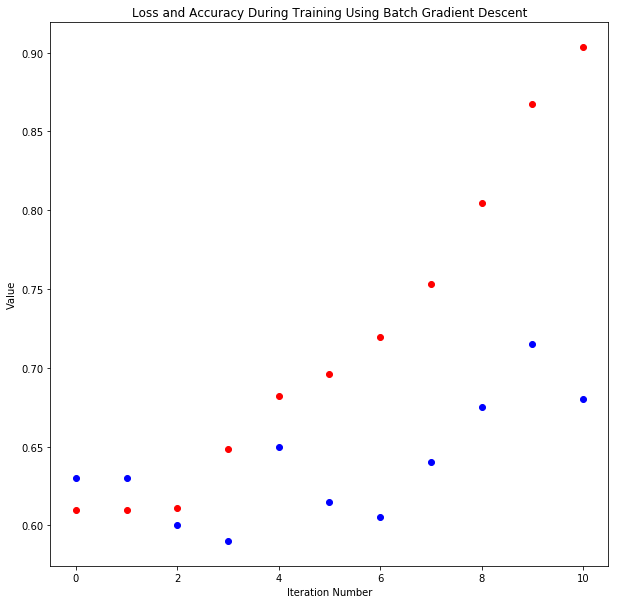

In [33]:
train_accuracies = []
val_accuracies = []
max_depth = 10
for i in range(max_depth + 1):
    new_tree = DecisionTree(trainData, trainLabels, ['depth', i], 0)
    train_accuracies.append(new_tree.score(trainData, trainLabels))
    val_accuracies.append(new_tree.score(valData, valLabels))

plt.figure(figsize=[7,7])
plt.plot(np.arange(max_depth + 1), train_accuracies, 'ro')
plt.plot(np.arange(max_depth + 1), val_accuracies, 'bo')
plt.title('Training/Validation Accuracy versus Tree Depth')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

## Accuracies as a Function of Tree Count

In [ ]:
f_train_accuracies = []
f_val_accuracies = []
max_trees = 9
for i in range(1, max_trees + 1, 2):
    new_forest = RandomForest(trainData, trainLabels, int(0.7 * trainLabels.size), i, ['depth', 10], True)
    f_train_accuracies.append(new_forest.score(trainData, trainLabels))
    f_val_accuracies.append(new_forest.score(valData, valLabels))

plt.figure(figsize=[7,7])
plt.plot(np.arange(len(f_train_accuracies)), f_train_accuracies, 'ro')
plt.plot(np.arange(len(f_train_accuracies)), f_val_accuracies, 'bo')
plt.title('Training/Validation Accuracy versus Tree Count')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()

/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/ipykernel/__main__.py:23: RuntimeWarning: invalid value encountered in log


Finished Random Forest with 1 trees
Finished Random Forest with 3 trees
Finished Random Forest with 5 trees
